- [17.2 - Robust Linear Regression](#17.2---Robust-Linear-Regression)
- [17.3 - Hierarchical Regression on Individuals within Groups](#17.3---Hierarchical-Regression-on-Individuals-within-Groups)
- [17.4 - Quadratic Trend and Weighted Data](#17.4---Quadratic-Trend-and-Weighted-Data)

## Chapter 17 - Metric Predicted Variable with One Metric Predictor

In [473]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
import pymc3 as pmc
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import gridspec
from sklearn import preprocessing
from scipy.stats import mode, norm, t
from IPython.display import Image
import theano.tensor as tt

pd.set_option('display.notebook_repr_html', False)

#%config InlineBackend.figure_formats = {'pdf',}
%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'
burnin = 25

f_dict = {'size':16}

In [12]:
# Below function takes an array as input.

def plot_posterior(dist, decimals=3, vert_ref=None, alpha=0.05, point_est='mode', burnin=0, y_labels=False, ax=None):
       
    color = '#87ceeb'
    font_d = {'size':14}
    
    if ax == None:
        ax = plt.gca()
               
    hpd_interval = np.round(pmc.hpd(dist[burnin:], alpha=alpha), decimals=decimals)

    # Histogram, Mode/Mean
    sns.distplot(dist[burnin:], kde=False, color=color, ax=ax)
    plot_height = ax.get_ylim()[1]
    
    if point_est == 'mode':
        p_est_value = mode(np.round(dist[burnin:], decimals=decimals))[0][0]
    else:
        p_est_value = np.round(np.mean(dist[burnin:]), decimals=decimals)
    
    ax.text(p_est_value, plot_height*.9, '{} = {}'.format(point_est, p_est_value),
            horizontalalignment='center', fontdict=font_d, clip_on=False)    

    # HPD interval
    ax.hlines(ax.get_ylim()[1]*0.01, *hpd_interval, linewidth=4)
    for interval_point in hpd_interval:
        ax.text(interval_point, plot_height*0.05, interval_point,
                horizontalalignment='center', fontdict=font_d)
    ax.text(np.mean(hpd_interval), plot_height*0.13, '{}% HPD'.format((1-alpha)*100),
            horizontalalignment='center', fontdict=font_d)

    # Reference line
    if vert_ref is None:
        ax.axvline(p_est_value, color='g', linestyle='dotted')
    else:
        ax.axvline(vert_ref, color='g', linestyle='dotted')

    # Set labels and axis
    if y_labels is False:
        ax.yaxis.set_visible(False)
        ax.spines['left'].set_visible(False)
    [ax.spines[spine].set_visible(False) for spine in ['right', 'top']]
    
    return(ax)

In [201]:
# Below function creates plots like 17.3 and 17.4.

def plot_grid(trace, burnin, data, sd_h, sd_w, mean_h, mean_w):
    plt.figure(figsize=(13,15))

    # Define gridspec
    gs = gridspec.GridSpec(4, 6)
    ax1 = plt.subplot(gs[:2,1:5])
    ax2 = plt.subplot(gs[2,:2])
    ax3 = plt.subplot(gs[2,2:4])
    ax4 = plt.subplot(gs[2,4:6])
    ax5 = plt.subplot(gs[3,:2])
    ax6 = plt.subplot(gs[3,2:4])                     
    ax7 = plt.subplot(gs[3,4:6])
        
    # Scatter plot observed data
    ax1.scatter(data.height, data.weight, s=40, linewidths=1, facecolor='none', zorder=10)
    ax1.set_xlabel('height', fontdict=f_dict)
    ax1.set_ylabel('height', fontdict=f_dict)
    ax1.set(xlim=(0,80), ylim=(-350,250))

    # Convert parameters to original scale
    beta0 = trace['beta0'][burnin:]*sd_w+mean_w-trace['beta1'][burnin:]*mean_h*sd_w/sd_h
    beta1 = trace['beta1'][burnin:]*(sd_w/sd_h)
    sigma = trace['sigma'][burnin:]*sd_w
    B = pd.DataFrame(np.c_[beta0, beta1], columns=['beta0', 'beta1'])
       
    # Credible regression lines from posterior
    hpd_interval = np.round(pmc.hpd(B.as_matrix(), alpha=0.05), decimals=3)
    B_hpd = B[B.beta0.between(*hpd_interval[0,:]) & B.beta1.between(*hpd_interval[1,:])] 
    xrange = np.arange(0, data.height.max()*1.05)
    for i in np.random.randint(0, len(B_hpd), 30):
        ax1.plot(xrange, B_hpd.iloc[i,0]+B_hpd.iloc[i,1]*xrange, c=color, alpha=.6, zorder=0)    
        
    # Intercept
    plot_posterior(beta0, ax=ax2)
    ax2.set_xlabel(r'$\beta_0$', fontdict=f_dict)
    ax2.set_title('Intercept', fontdict={'weight':'bold'})
    
    # Slope
    plot_posterior(beta1, ax=ax3)
    ax3.set_xlabel(r'$\beta_1$', fontdict=f_dict)
    ax3.set_title('Slope', fontdict={'weight':'bold'})
    
    # Scatter plot beta1, beta0
    ax4.scatter(beta1, beta0, edgecolor=color, facecolor='none', alpha=.6)
    ax4.set_xlabel(r'$\beta_1$', fontdict=f_dict)
    ax4.set_ylabel(r'$\beta_0$', fontdict=f_dict)
    
    # Scale
    plot_posterior(sigma, ax=ax5)
    ax5.set_xlabel(r'$\sigma$', fontdict=f_dict)
    ax5.set_title('Scale', fontdict={'weight':'bold'})

    # Normality
    plot_posterior(np.log10(trace['nu'][burnin:]), ax=ax6)
    ax6.set_xlabel(r'log10($\nu$)', fontdict=f_dict)
    ax6.set_title('Normality', fontdict={'weight':'bold'})
    
    # Scatter plot normality, sigma
    ax7.scatter(np.log10(trace['nu'][burnin:]), sigma,
                edgecolor=color, facecolor='none', alpha=.6)
    ax7.set_xlabel(r'log10($\nu$)', fontdict=f_dict)
    ax7.set_ylabel(r'$\sigma$', fontdict=f_dict)
    
    plt.tight_layout()
    
    return(plt.gcf());

In [386]:
def plot_cred_lines(dist, burnin, x, sd_x, sd_y, mean_x, mean_y, ax):
# Convert parameters to original scale
    beta0 = dist[burnin:,0]*sd_y+mean_y-dist[burnin:,1]*mean_x*sd_y/sd_x
    beta1 = dist[burnin:,1]*(sd_y/sd_x)
    B = pd.DataFrame(np.c_[beta0, beta1], columns=['beta0', 'beta1'])

    # Credible regression lines from posterior
    hpd_interval = np.round(pmc.hpd(B.as_matrix(), alpha=0.05), decimals=3)
    hpd_interval = pmc.hpd(B.as_matrix(), alpha=0.05)
    B_hpd = B[B.beta0.between(*hpd_interval[0,:]) & B.beta1.between(*hpd_interval[1,:])] 
    xrange = np.arange(x.min()*.95, x.max()*1.05)
    for i in np.random.randint(0, len(B_hpd), 30):
        ax.plot(xrange, B_hpd.iloc[i,0]+B_hpd.iloc[i,1]*xrange, c=color, alpha=.6, zorder=0)    

In [454]:
def plot_quad_credlines(dist, burnin, x, sd_x, sd_y, mean_x, mean_y, ax):
# Convert parameters to original scale
    beta0 = dist[burnin:,0]*sd_y+mean_y-dist[burnin:,1]*mean_x*sd_y/sd_x + dist[burnin:,2]*mean_x**2*sd_y/sd_x**2
    beta1 = dist[burnin:,1]*sd_y/sd_x - 2*dist[burnin:,2]*mean_x*sd_y/sd_x**2
    beta2 = dist[burnin:,2]*sd_y/sd_x**2
    B = pd.DataFrame(np.c_[beta0, beta1, beta2], columns=['beta0', 'beta1', 'beta2'])

    # Credible regression lines from posterior
    hpd_interval = pmc.hpd(B.as_matrix(), alpha=0.05)
    B_hpd = B[B.beta0.between(*hpd_interval[0,:]) & B.beta1.between(*hpd_interval[1,:]) & B.beta2.between(*hpd_interval[2,:])] 
    xrange = np.arange(x.min()-1, x.max()+2)
    for i in np.random.randint(0, len(B_hpd), 30):
        ax.plot(xrange, B_hpd.iloc[i,0]+B_hpd.iloc[i,1]*xrange+B_hpd.iloc[i,2]*xrange**2, c=color, alpha=.6, zorder=0)    

### 17.2 - Robust Linear Regression

#### Model (Kruschke, 2015)

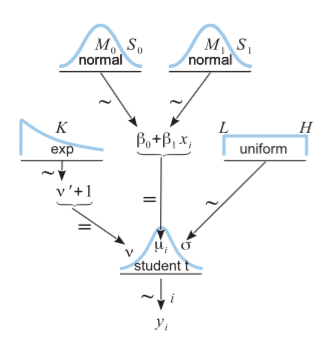

In [9]:
Image('images/fig17_2.png', width=400)

#### N = 30

In [4]:
df_n30 = pd.read_csv('data/HtWtData30.csv')
df_n30.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
male      30 non-null int64
height    30 non-null float64
weight    30 non-null float64
dtypes: float64(2), int64(1)
memory usage: 800.0 bytes


In [5]:
df_n30.head()

   male  height  weight
0     0    64.0   136.4
1     0    62.3   215.1
2     1    67.9   173.6
3     0    64.2   117.3
4     0    64.8   123.3

In [394]:
sd_h = df_n30.height.std()
mean_h = df_n30.height.mean()
zheight = (df_n30.height - mean_h)/sd_h

sd_w = df_n30.weight.std()
mean_w = df_n30.weight.mean()
zy = (df_n30.weight - mean_w)/sd_w

#### Model

In [ ]:
with pmc.Model() as model:
    
    beta0 = pmc.Normal('beta0', mu=0, tau=1/10**2)
    beta1 = pmc.Normal('beta1', mu=0, tau=1/10**2)
    mu =  beta0 + beta1*zheight.ravel()
    
    sigma = pmc.Uniform('sigma', 10**-3, 10**3)
    nu = pmc.Exponential('nu', 1/29)
    
    likelihood = pmc.StudentT('likelihood', nu, mu=mu, sd=sigma, observed=zweight.ravel())

In [501]:
with model:
    trace = pmc.sample(3000)

Assigned NUTS to beta0
Assigned NUTS to beta1
Assigned NUTS to sigma_interval_
Assigned NUTS to nu_log_
 [-----------------100%-----------------] 3001 of 3000 complete in 123.2 sec

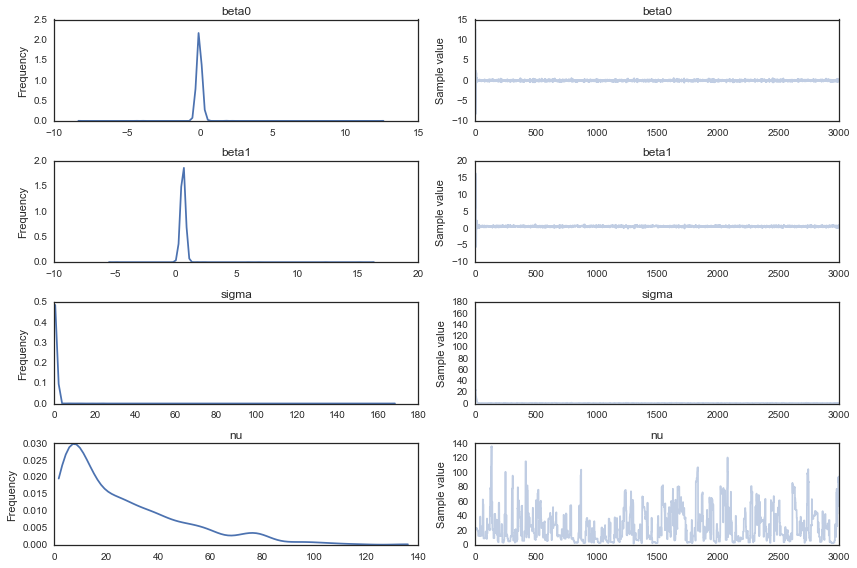

In [503]:
pmc.traceplot(trace);

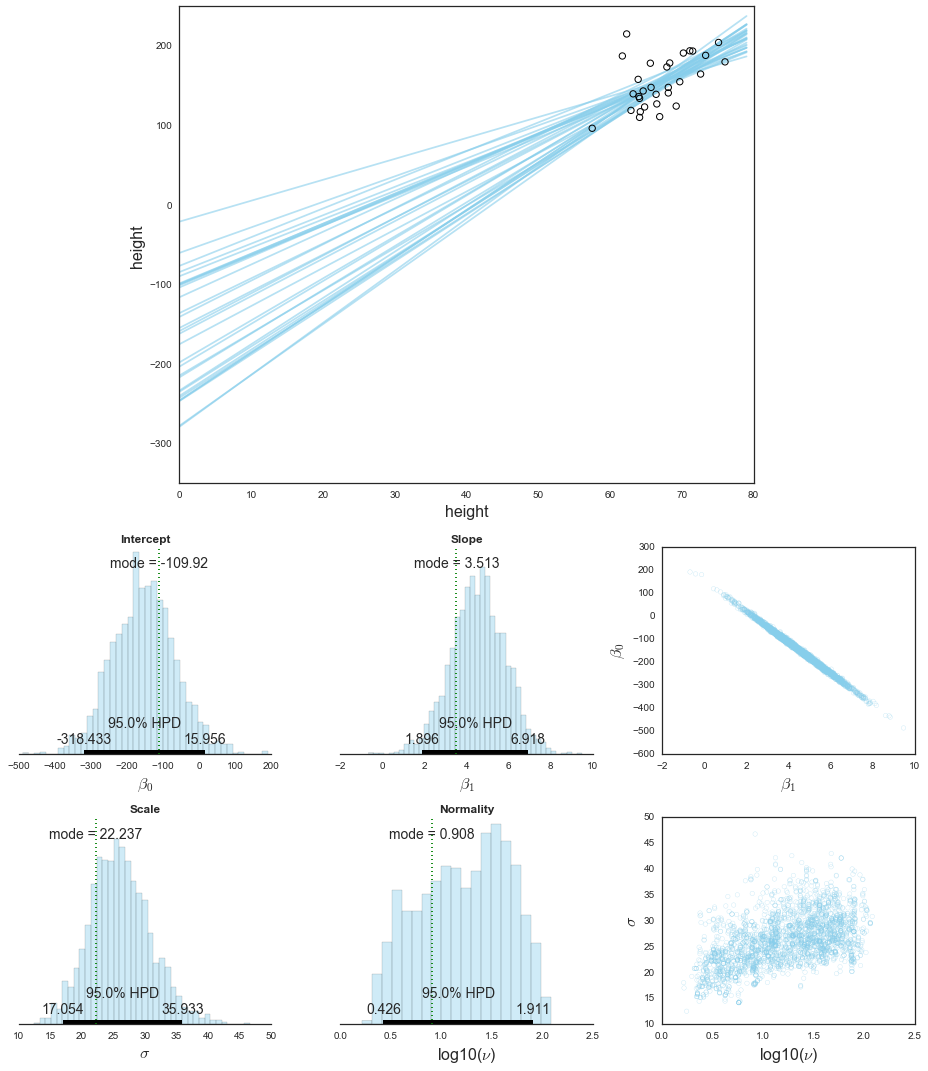

In [504]:
plot_grid(trace, 200, df_n30, sd_h, sd_w, mean_h, mean_w);

#### N = 300

In [59]:
df_n300 = pd.read_csv('data/HtWtData300.csv')
df_n300.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
male      300 non-null int64
height    300 non-null float64
weight    300 non-null float64
dtypes: float64(2), int64(1)
memory usage: 7.1 KB


In [395]:
sd_h2 = df_n300.height.std()
mean_h2 = df_n300.height.mean()
zheight2 = (df_n300.height - mean_h2)/sd_h2

sd_w2 = df_n300.weight.std()
mean_w2 = df_n300.weight.mean()
zy2 = (df_n300.weight - mean_w2)/sd_w2

#### Model

In [502]:
with pmc.Model() as model2:
    
    beta0 = pmc.Normal('beta0', mu=0, tau=1/10**2)
    beta1 = pmc.Normal('beta1', mu=0, tau=1/10**2)
    mu =  beta0 + beta1*zheight2.ravel()
    
    sigma = pmc.Uniform('sigma', 10**-3, 10**3)
    nu = pmc.Exponential('nu', 1/29)
    
    likelihood = pmc.StudentT('likelihood', nu, mu=mu, sd=sigma, observed=zweight2.ravel())    

In [505]:
with model2:
    trace2 = pmc.sample(3000)

Assigned NUTS to beta0
Assigned NUTS to beta1
Assigned NUTS to sigma_interval_
Assigned NUTS to nu_log_
 [-----------------100%-----------------] 3000 of 3000 complete in 373.2 sec

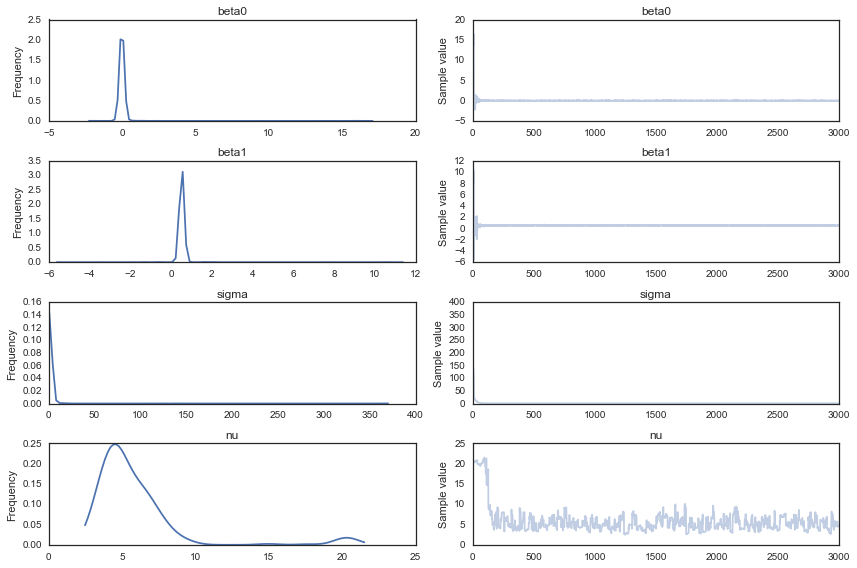

In [506]:
pmc.traceplot(trace2);

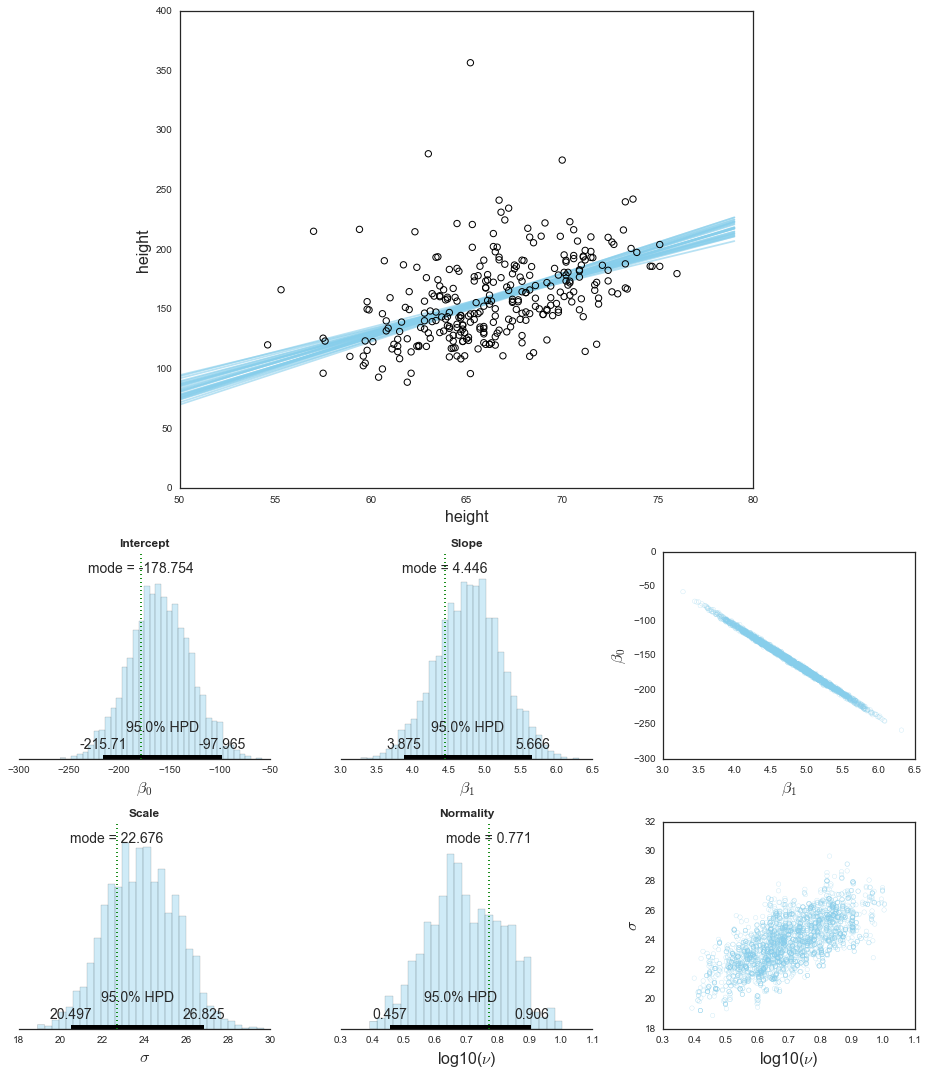

In [507]:
grid = plot_grid(trace2, 200, df_n300, sd_h2, sd_w2, mean_h2, mean_w2)
grid.axes[0].set_xlim(50,80)
grid.axes[0].set_ylim(0,400);

### 17.3 - Hierarchical Regression on Individuals within Groups

#### Model (Kruschke, 2015)

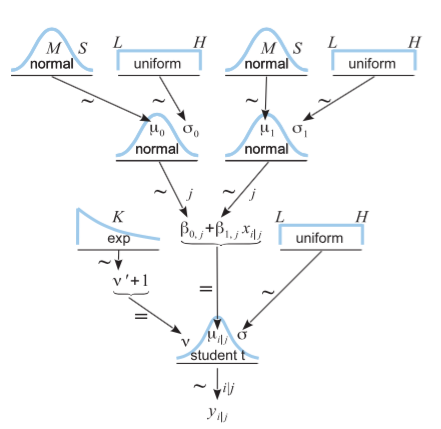

In [250]:
Image('images/fig17_6.png', width=500)

In [326]:
df_HRegr = pd.read_csv('data/HierLinRegressData.csv')
df_HRegr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 3 columns):
Subj    132 non-null int64
X       132 non-null float64
Y       132 non-null float64
dtypes: float64(2), int64(1)
memory usage: 3.2 KB


In [327]:
df_HRegr.head()

   Subj     X      Y
0     1  60.2  145.6
1     1  61.5  157.3
2     1  61.7  165.6
3     1  62.3  158.8
4     1  67.6  196.1

In [328]:
le = preprocessing.LabelEncoder()
subj_idx = le.fit_transform(df_HRegr.Subj)
subj_codes = le.classes_
n_subj = len(le.classes_)

print('Number of groups: {}'.format(n_subj))

Number of groups: 25


In [372]:
sd_x = df_HRegr.X.std()
mean_x = df_HRegr.X.mean()
zx = (df_HRegr.X - mean_x)/sd_x

sd_y = df_HRegr.Y.std()
mean_y = df_HRegr.Y.mean()
zy = (df_HRegr.Y - mean_y)/sd_y

#### Model

In [373]:
with pmc.Model() as model3:
    
    beta0 = pmc.Normal('beta0', mu=0, tau=1/10**2)
    beta1 = pmc.Normal('beta1', mu=0, tau=1/10**2)
    
    sigma0 = pmc.Uniform('sigma0', 10**-3, 10**3)
    sigma1 = pmc.Uniform('sigma1', 10**-3, 10**3)
    
    beta0_s = pmc.Normal('beta0_s', mu=beta0, sd=sigma0, shape=n_subj)
    beta1_s = pmc.Normal('beta1_s', mu=beta1, sd=sigma1, shape=n_subj)
    
    mu =  beta0_s[subj_idx] + beta1_s[subj_idx] * zx
    
    sigma = pmc.Uniform('sigma', 10**-3, 10**3)
    nu = pmc.Exponential('nu', 1/29.)
    
    likelihood = pmc.StudentT('likelihood', nu, mu=mu, sd=sigma, observed=zy)    

Applied interval-transform to sigma0 and added transformed sigma0_interval_ to model.
Applied interval-transform to sigma1 and added transformed sigma1_interval_ to model.
Applied interval-transform to sigma and added transformed sigma_interval_ to model.
Applied log-transform to nu and added transformed nu_log_ to model.


In [374]:
with model3:
    trace3 = pmc.sample(1000)

Assigned NUTS to beta0
Assigned NUTS to beta1
Assigned NUTS to sigma0_interval_
Assigned NUTS to sigma1_interval_
Assigned NUTS to beta0_s
Assigned NUTS to beta1_s
Assigned NUTS to sigma_interval_
Assigned NUTS to nu_log_
 [-----------------100%-----------------] 1000 of 1000 complete in 162.6 sec

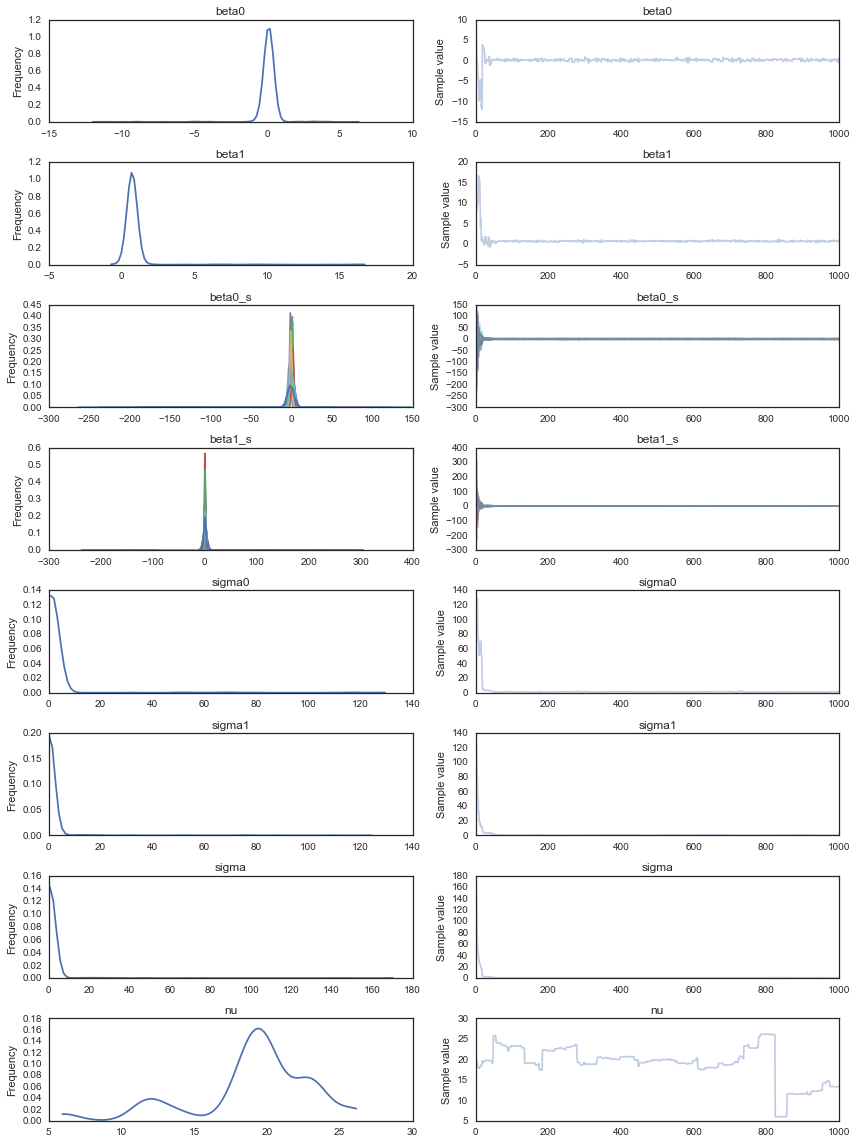

In [375]:
pmc.traceplot(trace3);

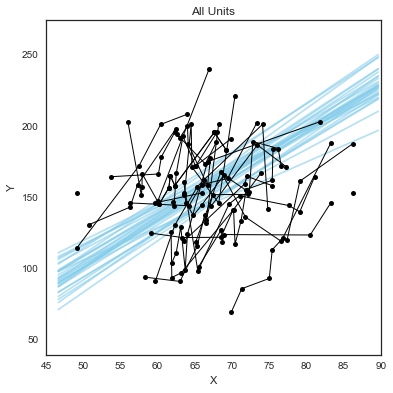

In [499]:
plt.figure(figsize=(6,6))
ax = plt.gca()

df_HRegr.groupby('Subj').apply(lambda group: ax.plot(group.X, group.Y, 'k-o', lw=1, markersize=5))
ax.set(xlabel='X', ylabel='Y', ylim=(40,275), title='All Units');

plot_cred_lines(np.c_[trace3['beta0'], trace3['beta1']], 100, df_HRegr.X, sd_x, sd_y, mean_x, mean_y, ax)

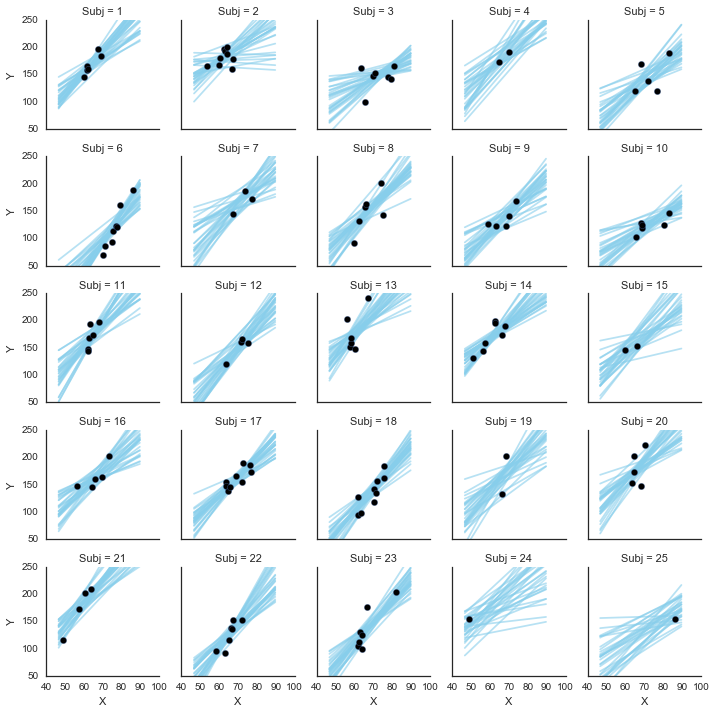

In [500]:
fg = sns.FacetGrid(df_HRegr, col='Subj', col_wrap=5, ylim=(50,250), size=2)
fg.map(plt.scatter, 'X', 'Y', c='k', s=40)

for i, ax in enumerate(fg.axes):
    plot_cred_lines(np.c_[trace3['beta0_s'][:,i], trace3['beta1_s'][:,i]],
                    100, df_HRegr.X, sd_x, sd_y, mean_x, mean_y, ax)

### 17.4 - Quadratic Trend and Weighted Data

In [348]:
df_income = pd.read_csv('data/IncomeFamszState3yr.csv', skiprows=1)
df_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 4 columns):
FamilySize      312 non-null int64
State           312 non-null object
MedianIncome    312 non-null int64
SampErr         312 non-null int64
dtypes: int64(3), object(1)
memory usage: 9.8+ KB


In [349]:
df_income.head()

   FamilySize    State  MedianIncome  SampErr
0           2  Alabama         48177      581
1           3  Alabama         53323     1177
2           4  Alabama         64899     1170
3           5  Alabama         59417     2446
4           6  Alabama         54099     3781

In [471]:
le = preprocessing.LabelEncoder()
state_idx = le.fit_transform(df_income.State)
state_codes = le.classes_
n_states = len(le.classes_)

print('Number of states: {}'.format(n_states))

Number of states: 52


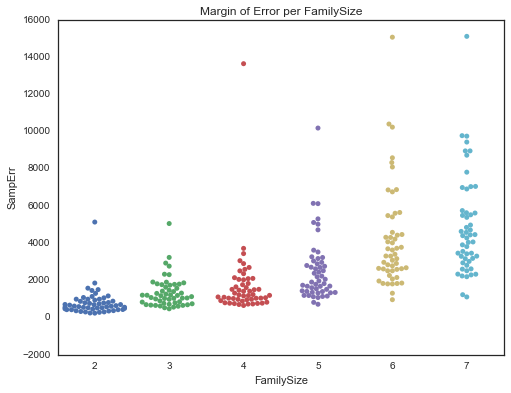

In [530]:
mean_fs = df_income.FamilySize.mean()
sd_fs = df_income.FamilySize.std()
z_fs = (df_income.FamilySize - mean_fs)/sd_fs

mean_income = df_income.MedianIncome.mean()
sd_income = df_income.MedianIncome.std()
z_income = (df_income.MedianIncome - mean_income)/sd_income

mean_error = df_income.SampErr.mean()
z_error = df_income.SampErr / mean_error

# There are fewer large-sized families than small-sized families, making the medians for income
# for the former group noisier. We can modulate the noise parameter with the margin of error. 
plt.figure(figsize=(8,6))
sns.swarmplot(x='FamilySize', y='SampErr', data=df_income)
plt.title('Margin of Error per FamilySize');

#### Model

In [487]:
with pmc.Model() as model4:
       
    beta0 = pmc.Normal('beta0', mu=0, tau=1/10**2)
    beta1 = pmc.Normal('beta1', mu=0, tau=1/10**2)
    beta2 = pmc.Normal('beta2', mu=0, tau=1/10**2)
    
    sigma0 = pmc.Uniform('sigma0', 10**-3, 10**3)
    sigma1 = pmc.Uniform('sigma1', 10**-3, 10**3)
    sigma2 = pmc.Uniform('sigma2', 10**-3, 10**3)
        
    beta0_s = pmc.Normal('beta0_s', mu=beta0, sd=sigma0, shape=n_states)
    beta1_s = pmc.Normal('beta1_s', mu=beta1, sd=sigma1, shape=n_states)
    beta2_s = pmc.Normal('beta2_s', mu=beta2, sd=sigma2, shape=n_states)
    
    mu =  beta0_s[state_idx] + beta1_s[state_idx] * z_fs + beta2_s[state_idx] * z_fs**2
    
    nu = pmc.Exponential('nu', 1/29.)
    sigma = pmc.Uniform('sigma', 10**-3, 10**3)
    
    # Modulate the noise parameter with the margin of error.
    w_sigma = tt.as_tensor(z_error)*sigma
        
    likelihood = pmc.StudentT('likelihood', nu=nu, mu=mu, sd=w_sigma, observed=z_income)    

Applied interval-transform to sigma0 and added transformed sigma0_interval_ to model.
Applied interval-transform to sigma1 and added transformed sigma1_interval_ to model.
Applied interval-transform to sigma2 and added transformed sigma2_interval_ to model.
Applied log-transform to nu and added transformed nu_log_ to model.
Applied interval-transform to sigma and added transformed sigma_interval_ to model.


In [492]:
with model4:
    trace4 = pmc.sample(1000)

Assigned NUTS to beta0
Assigned NUTS to beta1
Assigned NUTS to beta2
Assigned NUTS to sigma0_interval_
Assigned NUTS to sigma1_interval_
Assigned NUTS to sigma2_interval_
Assigned NUTS to beta0_s
Assigned NUTS to beta1_s
Assigned NUTS to beta2_s
Assigned NUTS to nu_log_
Assigned NUTS to sigma_interval_
 [-----------------100%-----------------] 1001 of 1000 complete in 50.2 sec

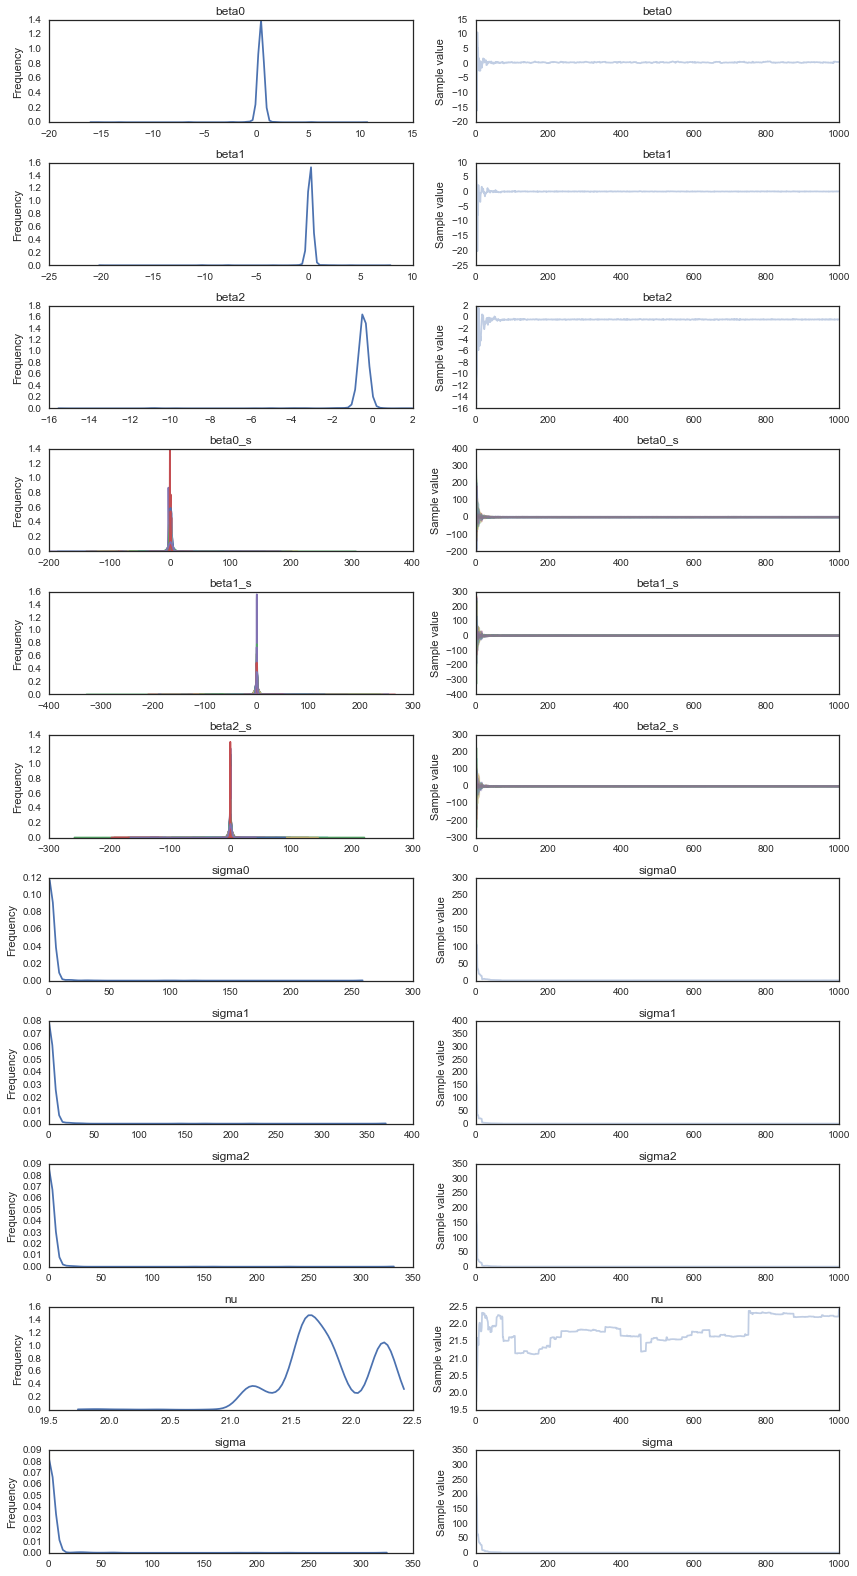

In [493]:
pmc.traceplot(trace4);

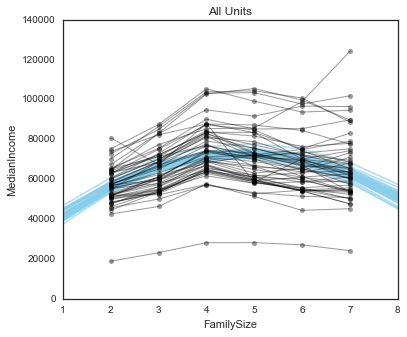

In [497]:
plt.figure(figsize=(6,5))
ax = plt.gca()

df_income.groupby('State').apply(lambda group: ax.plot(group.FamilySize,
                                                       group.MedianIncome,
                                                       'k-o', lw=1, markersize=5, alpha=.4))
ax.set(xlabel='FamilySize', ylabel='MedianIncome', xlim=(1,8), title='All Units');

plot_quad_credlines(np.c_[trace4['beta0'], trace4['beta1'], trace4['beta2']],
                    200, df_income.FamilySize, sd_fs, sd_income, mean_fs, mean_income, ax)

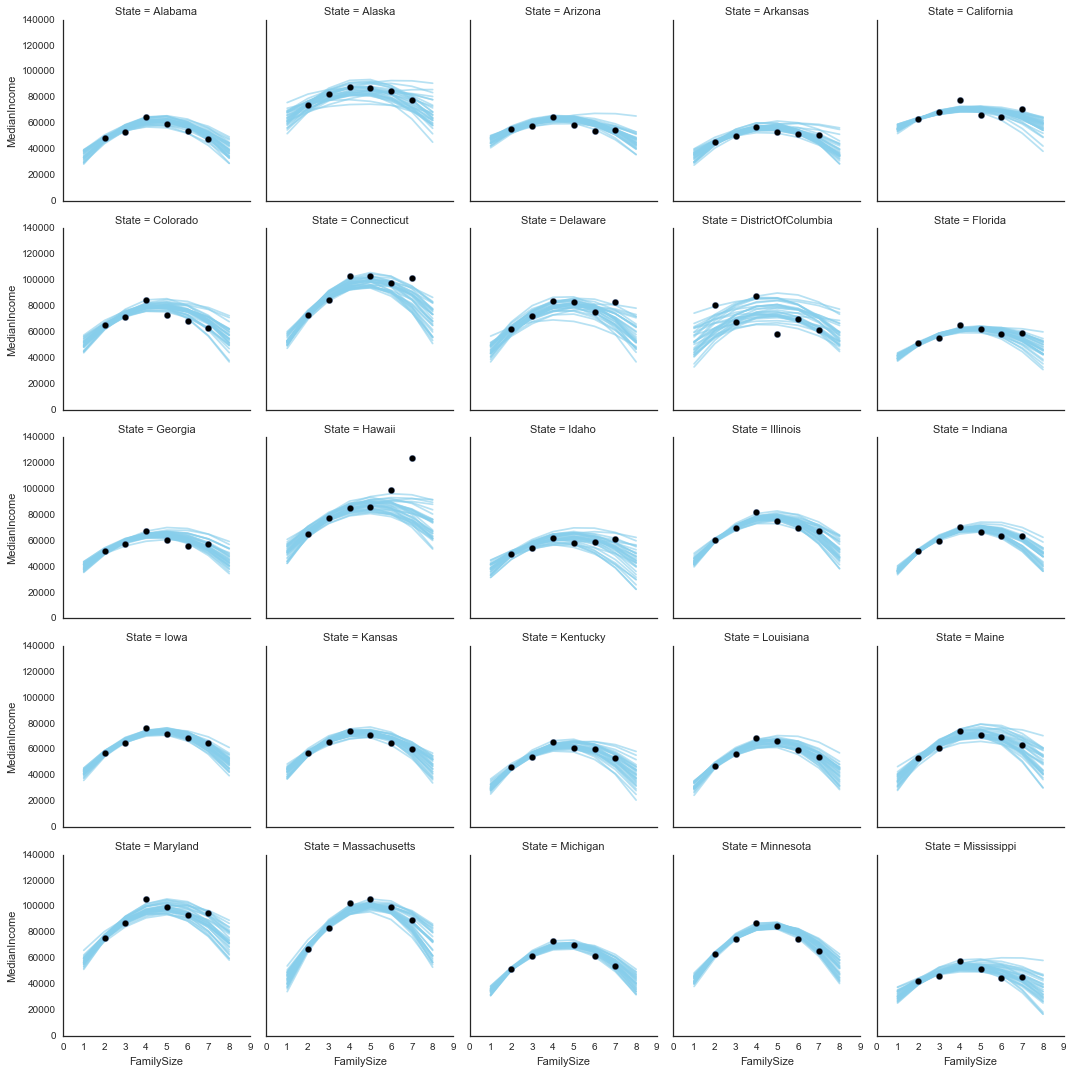

In [496]:
# The book shows the data for the first 25 States.
# Indexing the dataframe with a callable function (new in pandas 18.1)
fg = sns.FacetGrid(df_income[lambda x: x.State.isin(df_income.State.unique()[:25])], col='State', col_wrap=5)
fg.map(plt.scatter, 'FamilySize', 'MedianIncome', c='k', s=40);

for i, ax in enumerate(fg.axes):
    plot_quad_credlines(np.c_[trace4['beta0_s'][:,i], trace4['beta1_s'][:,i], trace4['beta2_s'][:,i]],
                    200, df_income.FamilySize, sd_fs, sd_income, mean_fs, mean_income, ax)